
# Chapter 4 - Moving Beyond Linearity

The following excercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

Make sure the following packages are installed prior to running code in this notebook:
- `numpy`
- `matplotlib`
- `seaborn`
- `statsmodels`
- `sklearn`
- `functools`
- `scipy`
- `pygam`
- `ISLP`

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.api import OLS
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit,
      train_test_split)
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.stats import norm
from pygam import (s, f, l, LinearGAM)
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS,
                         sklearn_sm,
                         bs,
                         ns,
                         Stepwise,
                         sklearn_selected,
                         sklearn_selection_path)
from ISLP.transforms import BSpline
from ISLP.pygam import (plot as plot_gam)

## Exercise: Predicting NO<sub>2</sub> Concentration
This exercise is adapted from Chapter 7, Exercise 9 in ISLP. 

In this exercise, we use the `Boston` data set, which is part of the `ISLP` package.  We will use two columns from this data: 
- `dis`: The weighted mean of distances to five Boston employment centers  
- `nox`: Nitrogen oxides concentration in parts per 10 million

We treat `dis` as the predictors and `nox` as the response.  Let's start by reading in the data and taking a look at a summary of the columns we're interested in.

In [2]:
boston = load_data('Boston')
boston[['dis', 'nox']].describe()

,dis,nox
count,506.000000,506.000000
mean,3.795043,0.554695
std,2.105710,0.115878
min,1.129600,0.385000
25%,2.100175,0.449000
50%,3.207450,0.538000
75%,5.188425,0.624000
max,12.126500,0.871000


In [3]:
boston[['dis', 'nox']].head(n = 5)

,dis,nox
0,4.0900,0.538
1,4.9671,0.469
2,4.9671,0.469
3,6.0622,0.458
4,6.0622,0.458


For simpler code later on, let's store our response `nox` in a variable called `y` and the column `dis` in a variable called `dis`.  

In [4]:
y = boston['nox']
dis = boston['dis']

Let's also split into a training and test set.  In some cases we'll use the train/test data, but in other cases we'll use the full data.

In [5]:
boston_train, boston_test = train_test_split(boston, random_state = 47, test_size = 0.15)

Once again we will save these train/test variables to simplify our code late on.

In [6]:
y_train = boston_train['nox']
dis_train = boston_train['dis']
y_test = boston_test['nox']
dis_test = boston_test['dis']

### Part 1: Cubic Polynomial Regression

Initial inspection of our variables shows the nonlinear relationship plotted below.

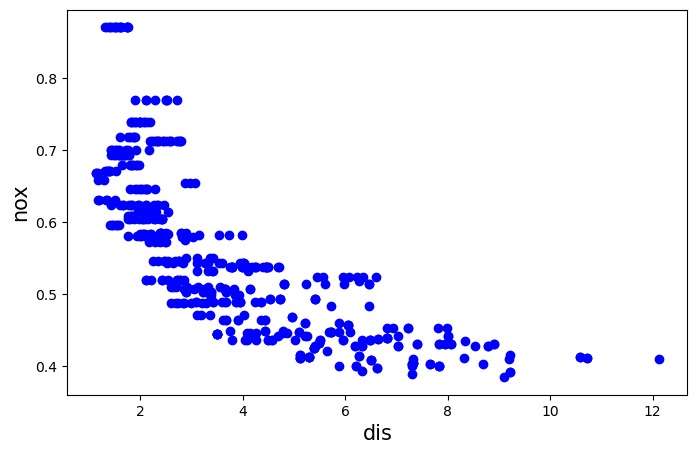

In [7]:
fig, ax = subplots(figsize = (8, 5))
ax.scatter(dis, y, color = 'blue')
ax.set_xlabel('dis', fontsize = 15)
ax.set_ylabel('nox', fontsize = 15);

With this in mind, we will begin by fitting a cubic polynomial regression model on our training data.  We will use the `poly()` function to create a model matrix that will fit a 3rd degree polynomial in `dis`.

In [8]:
poly_dis = MS([poly('dis', degree = 3)]).fit(boston_train)
M = sm.OLS(y_train, poly_dis.transform(boston_train)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5572,0.003,180.780,0.0
"poly(dis, degree=3)[0]",-1.8905,0.064,-29.579,0.0
"poly(dis, degree=3)[1]",0.8255,0.064,12.917,0.0
"poly(dis, degree=3)[2]",-0.3272,0.064,-5.119,0.0


Now let's predict on our test set.  The code below gets the predictions,  stores the predictions, copies the dataframe and then sorts by `dis`. The plot shows the training points in blue and the fitted line from the testing data in red. 

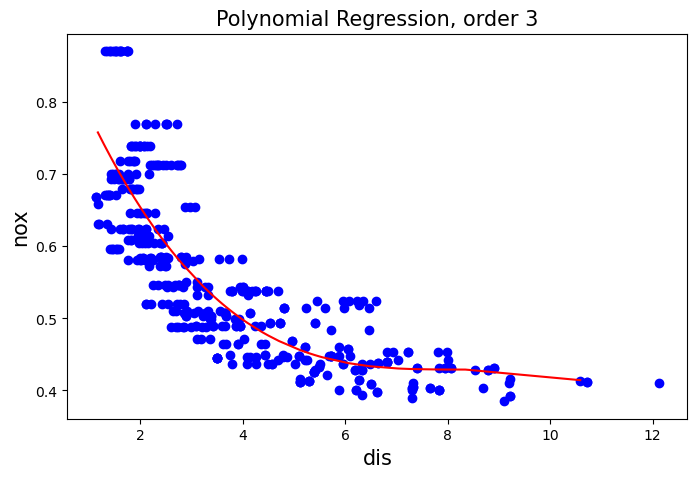

In [9]:
preds = M.predict(exog = poly_dis.transform(boston_test))
boston_test['preds'] = preds
boston_test_plt = boston_test.sort_values(by = 'dis')

fig, ax = subplots(figsize = (8, 5))
ax.scatter(dis_train, y_train, color = 'blue')
ax.plot(boston_test_plt['dis'], boston_test_plt['preds'], linestyle = '-',  color = 'red')
ax.set_title("Polynomial Regression, order 3", fontsize = 15)
ax.set_xlabel('dis', fontsize = 15)
ax.set_ylabel('nox', fontsize = 15);

### Part 2: Different Degree Polynomial Regressions

Now we'll try out different degree polynomials. The following loop fits polynomial regression of orders 1-10 and plots the fitted model.    

Note: These polynomials are being fit to the entire data set.

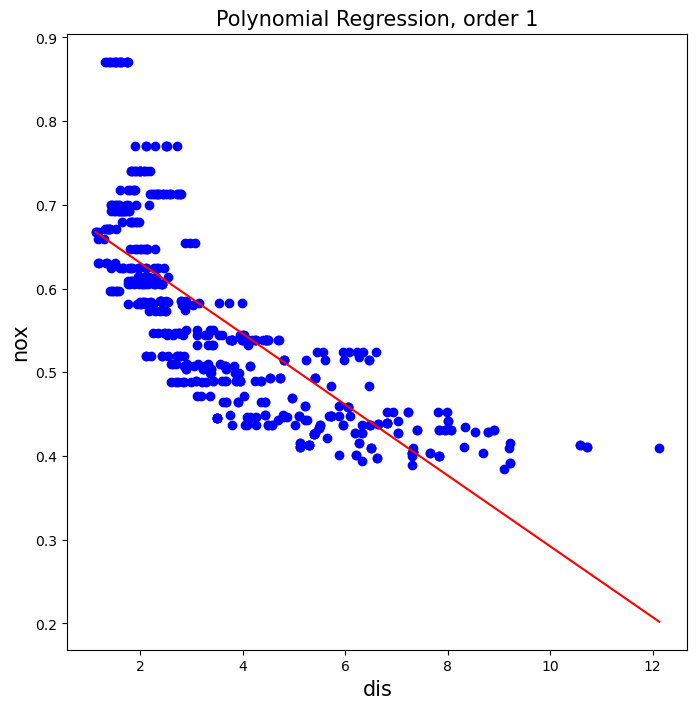

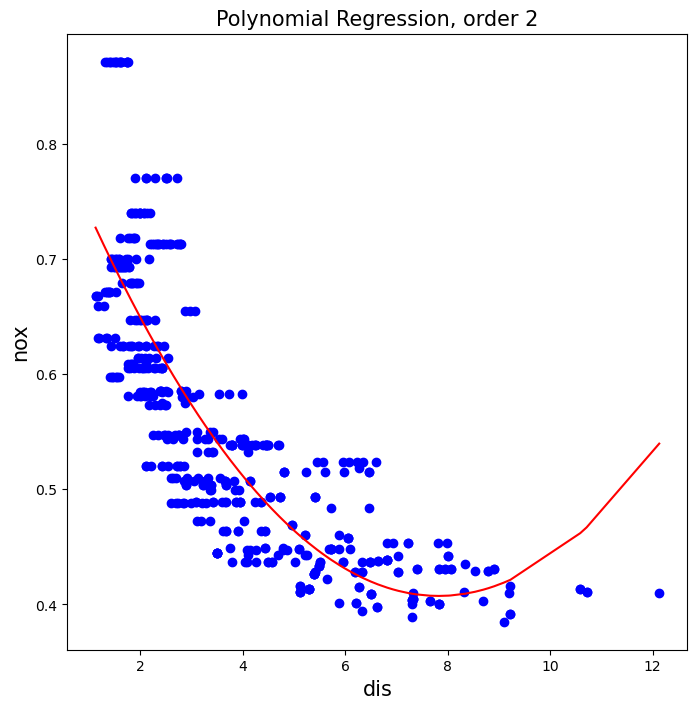

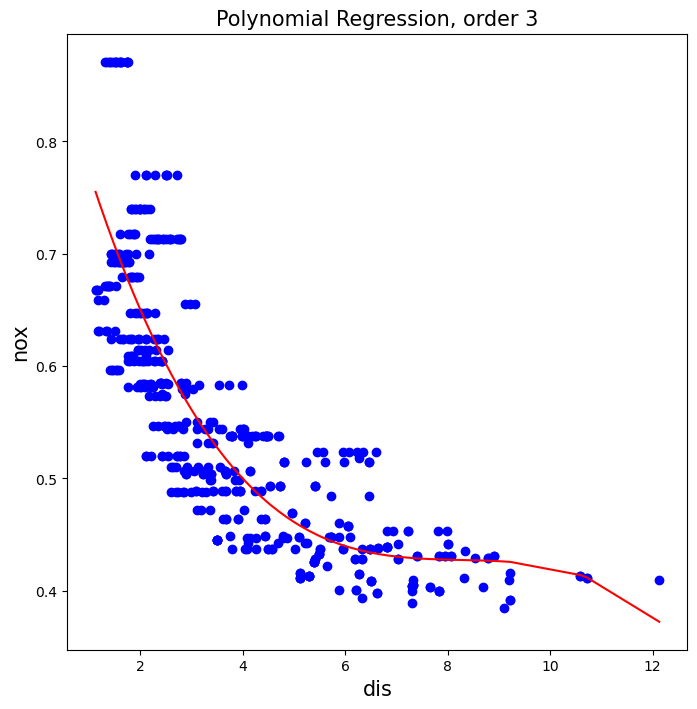

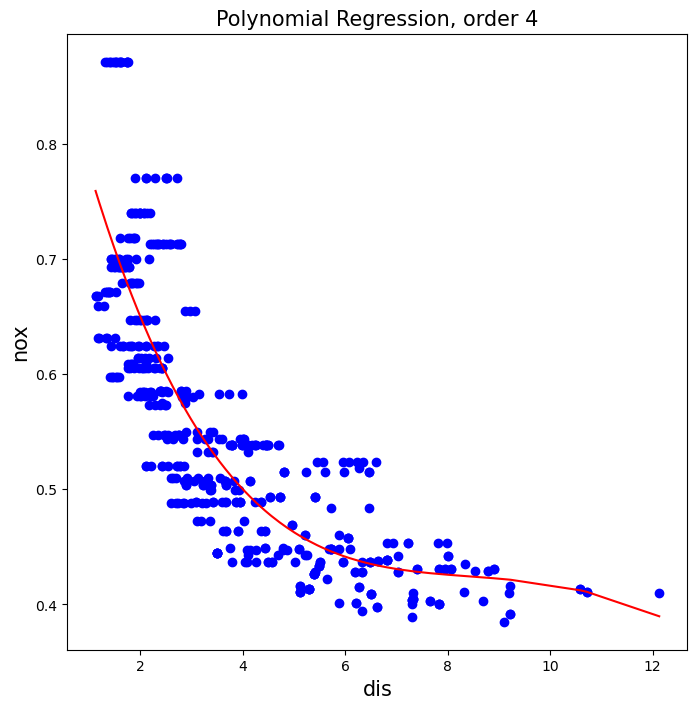

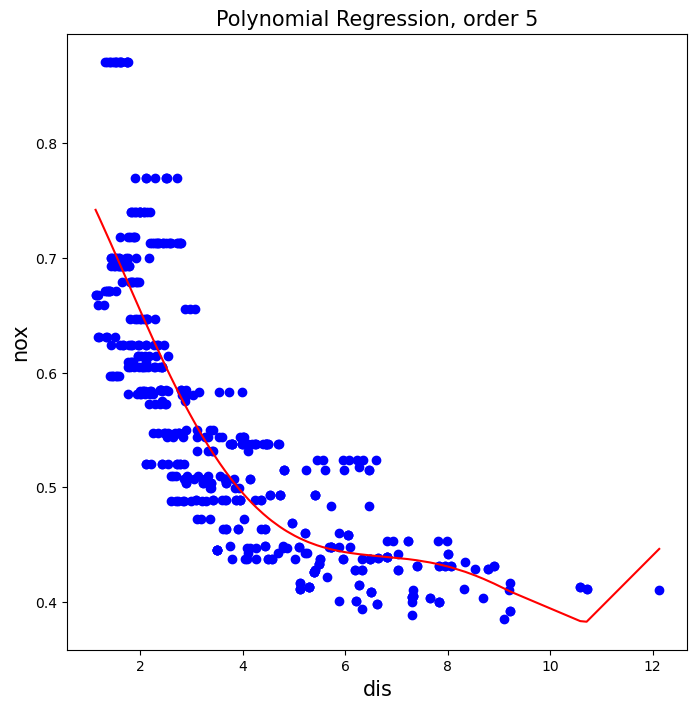

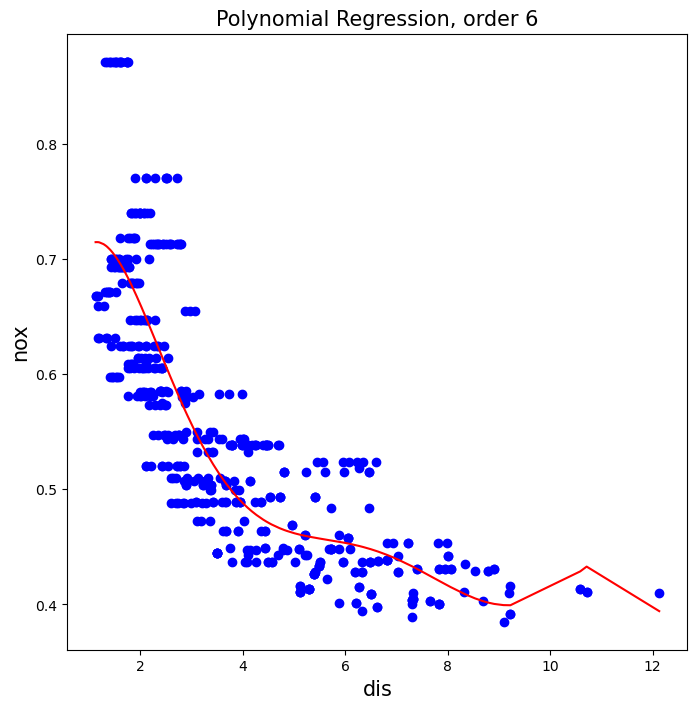

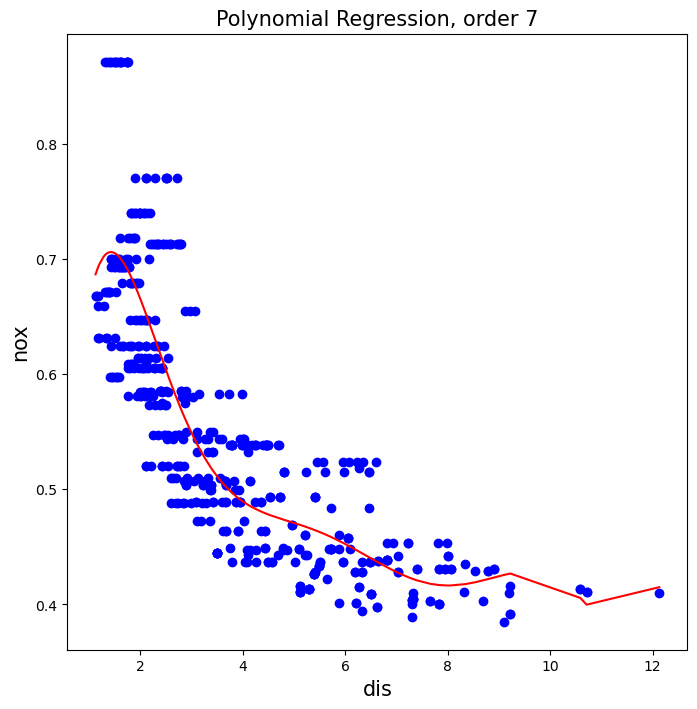

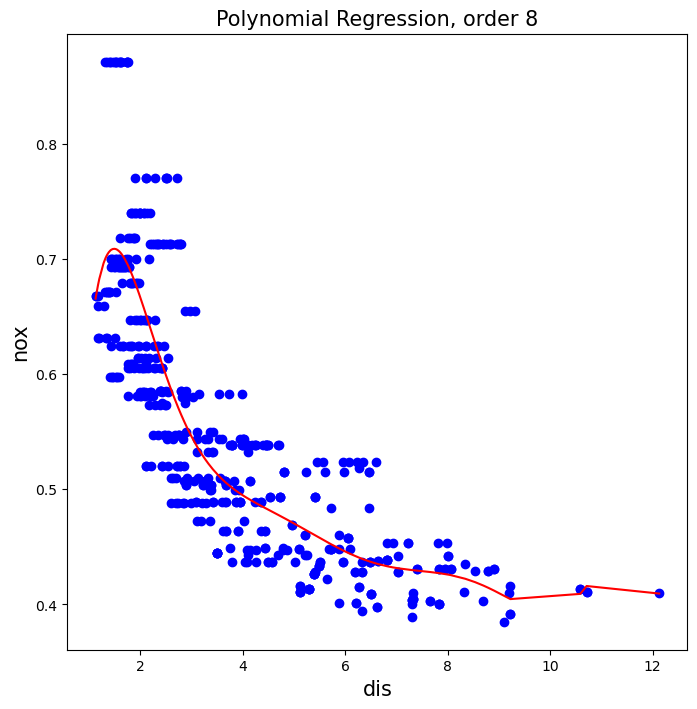

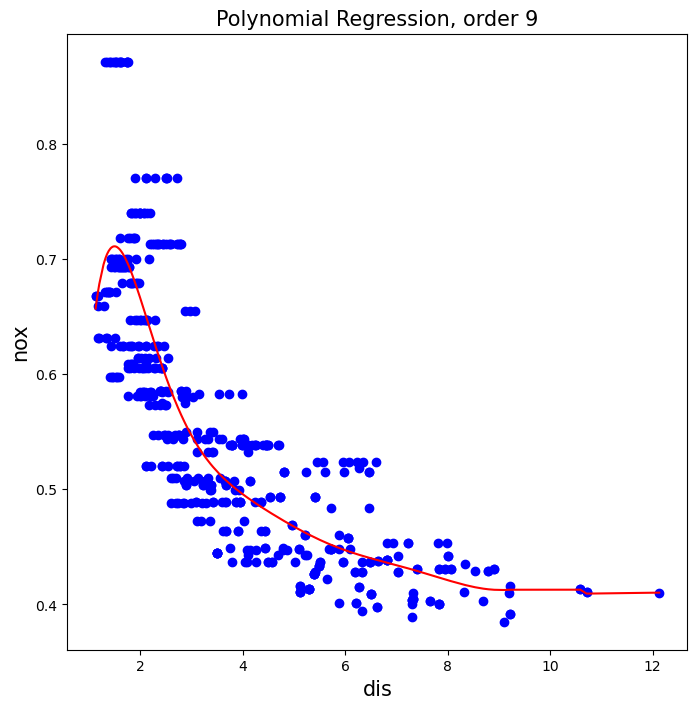

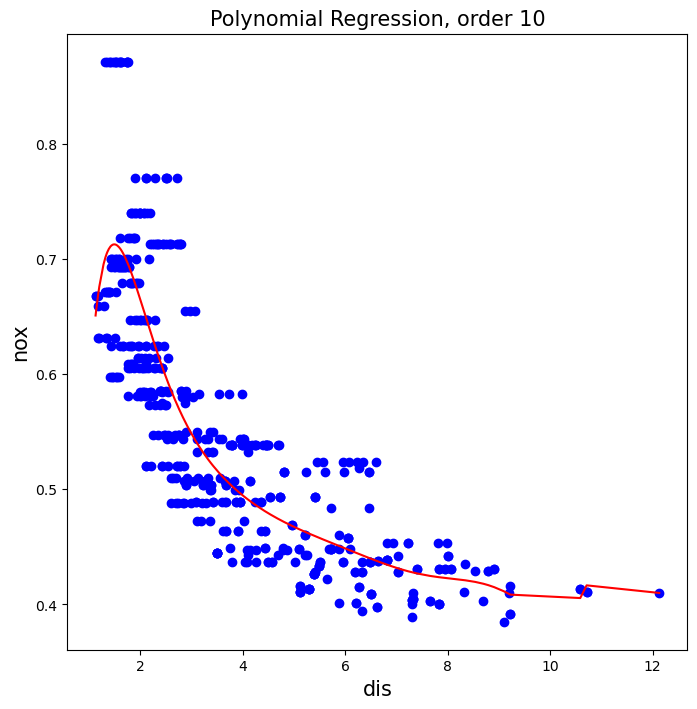

In [10]:
for df in range(1, 11):
    fig, ax = subplots(figsize = (8, 8))
    ax.scatter(dis, y, color = 'blue')
    poly_dis = MS([poly('dis', degree = df)]).fit(boston)
    M = sm.OLS(y, poly_dis.transform(boston)).fit()
    preds = M.predict(exog = poly_dis.transform(boston))
    
    boston['preds_poly' + str(df)] = preds
    boston_plt = boston.sort_values(by = 'dis')

    ax.plot(boston_plt['dis'], boston_plt['preds_poly' + str(df)], linestyle = '-',  color = 'red')
    ax.set_title("Polynomial Regression, order " + str(df), fontsize = 15)
    ax.set_xlabel('dis', fontsize = 15)
    ax.set_ylabel('nox', fontsize = 15);

To get a more succinct summary of these models, the following code fits polynomial regression degrees 1-10 using the `anova_lm()` and `sm.OLS()` functions. Notice the `*` in the `anova_lm()` line above. This
function takes a variable number of non-keyword arguments, in this case fitted models.  When these models are provided as a list (as is done here), it must be prefixed by `*`.

In [11]:
models = [MS([poly('dis', degree=d)]) 
          for d in range(1, 11)]
Xs = [model.fit_transform(boston) for model in models]
Ms = [sm.OLS(y, X_).fit()
           for X_ in Xs]
anova_lm(*Ms)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,2.768563,0.0,NaN,NaN,NaN
1,503.0,2.035262,1.0,0.733301,198.116860,3.558589e-38
2,502.0,1.934107,1.0,0.101155,27.329219,2.522104e-07
3,501.0,1.932981,1.0,0.001125,0.304045,5.816033e-01
4,500.0,1.915290,1.0,0.017691,4.779699,2.926006e-02
5,499.0,1.878257,1.0,0.037033,10.005161,1.656138e-03
6,498.0,1.849484,1.0,0.028774,7.773823,5.503632e-03
7,497.0,1.835630,1.0,0.013854,3.742933,5.359844e-02
8,496.0,1.833331,1.0,0.002299,0.621093,4.310180e-01
9,495.0,1.832171,1.0,0.001160,0.313312,5.759079e-01


Note: indexing starts at 0 so the linear fit (degree = 1) is actually the line labeled 0. 

From the result, we can see that the `ssr` (RSS) gets smaller as we add the ith order of predictor. The change of RSS stays quite still after adding 5th order of `dis`.

#### K-fold Cross-Validation

Let's now explore how we might use K-fold cross-validation to select the degree of polynomial we want in our model. We'll first use `KFold` to partition the data into 10 folds.   

In [12]:
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)

We'll also initialize a vector that will store the MSE for each degree.

In [13]:
cv_mse = np.zeros(10)

We'll also use the wrapper `sklearn_sm` from the `ISLP` package around `sm.OLS` to specify our model (see Chapter 5).

In [14]:
M = sklearn_sm(sm.OLS)

Lastly, we'll create an `np.array` version of `dis` which we'll store in `D`.

In [15]:
D = np.array(dis)

Now let's loop through models of degree 1-10 and store the MSE for each.

In [16]:
for i, d in enumerate(range(1,11)):
    X = np.power.outer(D, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=cv)
    cv_mse[i] = np.mean(M_CV['test_score'])

Now we can see what the MSE is for each of these models.

In [17]:
print(cv_mse)

[0.00551987 0.00406038 0.0038537  0.00386949 0.00408708 0.00525387
 0.00877212 0.00580595 0.0164019  0.00847663]


Let's look at this in a plot to make it easier to see what's going on with the MSE.

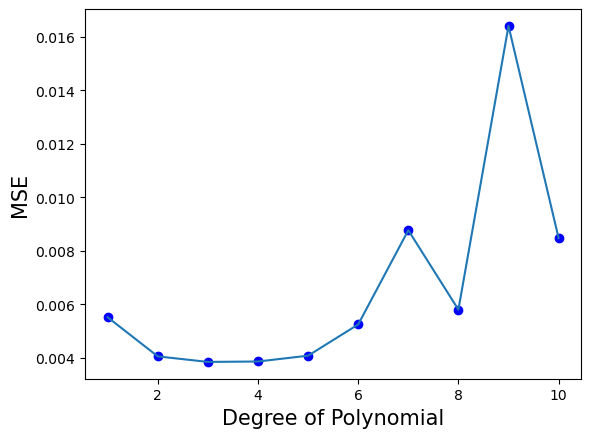

In [18]:
plt.scatter(range(1, 11), cv_mse, marker = 'o', color = 'blue')
plt.plot(range(1,11), cv_mse, label='Line')
plt.xlabel('Degree of Polynomial', fontsize = 15)
plt.ylabel('MSE', fontsize = 15);

### Part 3: Regression Spline
Next we try the regression spline approach.  In order to fit regression splines, we use transforms
from the `ISLP` package. The actual spline
evaluation functions are in the `scipy.interpolate` package; we have simply wrapped them as transforms
similar to `Poly()` and `PCA()`.

#### Specifying by Knots

One way to fit a regression spline is by specifying the number or location of knots.  The `BSpline()`  function generates the
entire matrix of basis functions for splines with the specified set of knots. By default, the B-splines produced are cubic. To change the degree, use the argument `degree`.

We'll start by fitting a regression spline with just one knot at the median value of `dis`.  The following code results in a five-column matrix, which is what is expected for a cubic-spline basis (the function uses degree 3 by default) with 1 interior knot at the median. Note, you don't have to put the knot at the median but that's what we choose here. 

In [19]:
bs_ = BSpline(internal_knots = [boston.dis.median()], intercept = True).fit(dis)
bs_dis = bs_.transform(dis)
bs_dis.shape

(506, 5)

Now we actually fit the cubic regression spline.

In [20]:
bs_dis = MS([bs('dis', internal_knots = [boston.dis.median()])])
Xbs = bs_dis.fit_transform(boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, internal_knots=[3.2074499999999997])[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, internal_knots=[3.2074499999999997])[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, internal_knots=[3.2074499999999997])[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, internal_knots=[3.2074499999999997])[3]",-0.3888,0.046,-8.544,0.000


Or for nicer looking output:

In [21]:
bs_dis = MS([bs('dis',
                internal_knots = [boston.dis.median()],
                name = 'bs(dis)')])
Xbs = bs_dis.fit_transform(boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
bs(dis)[0],-0.0581,0.022,-2.658,0.008
bs(dis)[1],-0.4636,0.024,-19.596,0.000
bs(dis)[2],-0.1998,0.043,-4.634,0.000
bs(dis)[3],-0.3888,0.046,-8.544,0.000


Notice that there are 4 spline coefficients rather than 5. This is because, by default, `bs()` assumes `intercept=False`, since we typically have an overall intercept in the model. So it generates the spline basis with the given knots,  and then discards one of the basis functions to account for the intercept. 

Now let's do this for 2 knots and 3 knots. We'll place our two knots at the median and 1st quartile. 

In [22]:
bs_dis2 = MS([bs('dis',
                internal_knots = [2.1, 3.21],
                name = 'bs(dis)')])
Xbs = bs_dis2.fit_transform(boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.6494,0.023,27.738,0.000
bs(dis)[0],0.1203,0.034,3.579,0.000
bs(dis)[1],-0.0376,0.023,-1.638,0.102
bs(dis)[2],-0.3015,0.036,-8.421,0.000
bs(dis)[3],-0.1766,0.043,-4.148,0.000
bs(dis)[4],-0.2702,0.052,-5.242,0.000


We'll place our three knots at the median, first and third quartiles.

In [23]:
bs_dis3 = MS([bs('dis',
                internal_knots = [2.1, 3.21],
                name = 'bs(dis)')])
Xbs = bs_dis3.fit_transform(boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.6494,0.023,27.738,0.000
bs(dis)[0],0.1203,0.034,3.579,0.000
bs(dis)[1],-0.0376,0.023,-1.638,0.102
bs(dis)[2],-0.3015,0.036,-8.421,0.000
bs(dis)[3],-0.1766,0.043,-4.148,0.000
bs(dis)[4],-0.2702,0.052,-5.242,0.000


From the ANOVA table, we can see the significance of the models sequentially. We can see that including the second knot gives a small p-value, so it is better to add that knot. However, adding the third knot is not significant meaning the model with three knots does not explain the data significantly better than the model with two knots (when that is the case we prefer the model with less parameters). Thus, we select the model with two knots. Let's predict using this model and plot what this looks like. 

Note: This is fit using the whole data set. The two gray lines show the location of our knots.

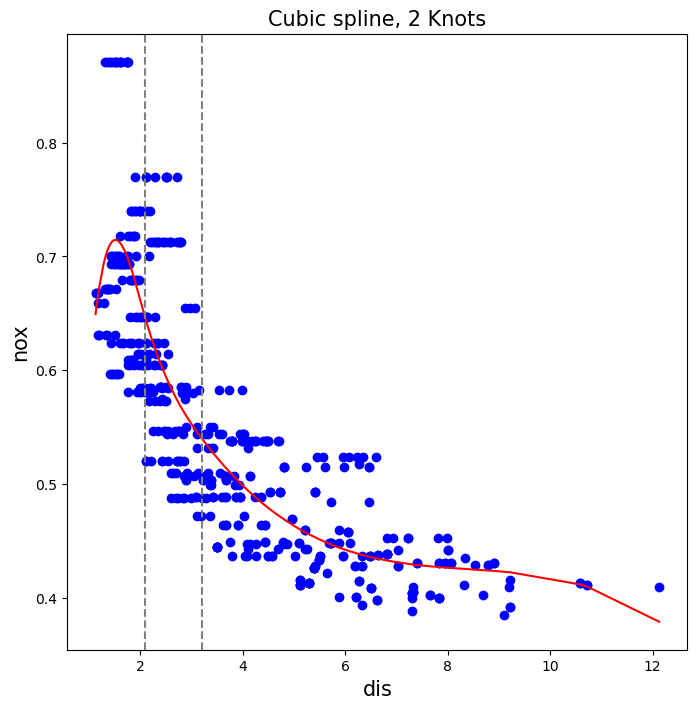

In [24]:
preds = M.predict(exog = bs_dis2.transform(boston))
boston['preds_bs2'] = preds
boston_plt = boston.sort_values(by = 'dis')

fig, ax = subplots(figsize=(8,8))
ax.scatter(boston['dis'], boston['nox'], 
           label='Points', color='blue')
ax.plot(boston_plt['dis'], boston_plt['preds_bs2'], 
        label='Connected Line', linestyle = '-',  color = 'red')
ax.axvline(x=2.1, color='grey', linestyle = '--', label = 'Knot 1')
ax.axvline(x=3.21, color='grey', linestyle = '--', label = 'Knot 2')
ax.set_title("Cubic spline, 2 Knots", fontsize = 15)
ax.set_xlabel('dis', fontsize = 15)
ax.set_ylabel('nox', fontsize = 15);

#### Specifying by degrees of freedom

We could also use the `df` (degrees of freedom) option to specify the complexity of the spline.  We see above that with 3 knots,
the spline basis has 6 rows or degrees of freedom.  For another example, when we specify `df = 6` rather than the actual knots, `bs()` will produce a spline with 3 knots chosen at uniform quantiles of the training data.  We can see the knots chosen from using `Bspline()` directly:

In [25]:
BSpline(df = 6).fit(dis).internal_knots_

array([2.100175, 3.20745 , 5.188425])

These knots correspond to the 25th, 50th, and 75th percentiles of `dis`.  Now let's fit a spline for 4-7 degrees of freedom (i.e. 1-4 knots) and print the RSS for each. We will also store the predictions for plotting later on.

In [26]:
bs_dis_df4 = MS([bs('dis', df = 4)]).fit(boston)
Xbs4 = bs_dis_df4.transform(boston)
M = sm.OLS(y, Xbs4).fit()
preds = M.predict(exog = bs_dis_df4.transform(boston))
boston['preds_bs_df4'] = preds
np.sum((y - preds)**2)

1.9227749928119253

In [27]:
bs_dis_df5 = MS([bs('dis', df = 5)]).fit(boston)
Xbs5 = bs_dis_df5.transform(boston)
M = sm.OLS(y, Xbs5).fit()
preds = M.predict(exog = bs_dis_df5.transform(boston))
boston['preds_bs_df5'] = preds
np.sum((y - preds)**2)

1.8401728014885235

In [28]:
bs_dis_df6 = MS([bs('dis', df = 6)]).fit(boston)
Xbs6 = bs_dis_df6.transform(boston)
M = sm.OLS(y, Xbs6).fit()
preds = M.predict(exog=bs_dis_df6.transform(boston))
boston['preds_bs_df6'] = preds
np.sum((y - preds)**2)

1.833965903160209

In [29]:
bs_dis_df7 = MS([bs('dis', df = 7)]).fit(boston)
Xbs7 = bs_dis_df7.transform(boston)
M = sm.OLS(y, Xbs7).fit()
preds = M.predict(exog=bs_dis_df7.transform(boston))
boston['preds_bs_df7'] = preds
np.sum((y - preds)**2)

1.829884445923284

Notice how RSS decreases as we add more degrees of freedom. Let's plot what each of these fits look like:

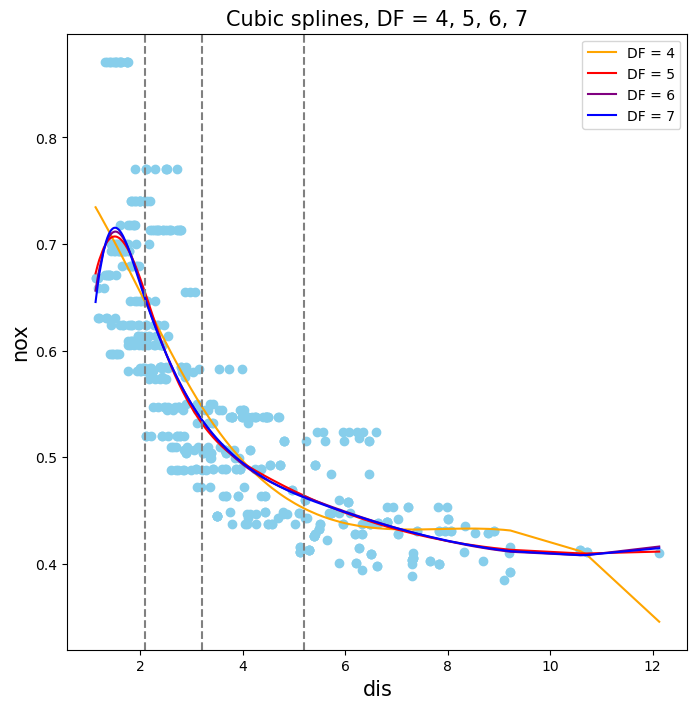

In [30]:
boston_plt = boston.sort_values(by = 'dis')

fig, ax = subplots(figsize = (8, 8))
ax.scatter(boston['dis'], boston['nox'], color = 'skyblue')
ax.plot(boston_plt['dis'], boston_plt['preds_bs_df4'], 
        label = 'DF = 4', linestyle = '-',  color = 'orange')
ax.plot(boston_plt['dis'], boston_plt['preds_bs_df5'], 
        label = 'DF = 5', linestyle = '-',  color = 'red')
ax.plot(boston_plt['dis'], boston_plt['preds_bs_df6'], 
        label = 'DF = 6', linestyle = '-',  color = 'purple')
ax.plot(boston_plt['dis'], boston_plt['preds_bs_df7'], 
        label = 'DF = 7', linestyle = '-',  color = 'blue')
ax.axvline(x = BSpline(df = 6).fit(dis).internal_knots_[0], color = 'grey', linestyle = '--')
ax.axvline(x = BSpline(df = 6).fit(dis).internal_knots_[1], color = 'grey', linestyle = '--')
ax.axvline(x = BSpline(df = 6).fit(dis).internal_knots_[2], color = 'grey', linestyle = '--')
ax.set_title("Cubic splines, DF = 4, 5, 6, 7", fontsize = 15)
ax.set_xlabel('dis', fontsize = 15)
ax.set_ylabel('nox', fontsize = 15)
ax.legend();

Now let's try more degrees of freedom.  We'll loop through df = 3-22 and plot the RSS to get a look at how it's changing based on degrees of freedom. We'll first initialize a vector for RSS and then do the loop.

In [31]:
df_rss = np.zeros(20)

for i, d in enumerate(range(1, 21)):
    bs_dis_df = MS([bs('dis',
                     df = d + 2)]).fit(boston)
    Xbs = bs_dis_df.transform(boston)
    M = sm.OLS(y, Xbs).fit()
    preds = M.predict(exog = bs_dis_df.transform(boston))
    df_rss[i] = np.sum((y - preds)**2)

Let's print the RSS values and plot them.

In [32]:
print(df_rss)

[1.93410671 1.92277499 1.8401728  1.8339659  1.82988445 1.81699506
 1.82565251 1.79253489 1.79699182 1.78899915 1.78235043 1.78183806
 1.78279784 1.78354577 1.77978868 1.77583847 1.77448747 1.77672728
 1.77466394 1.7702632 ]


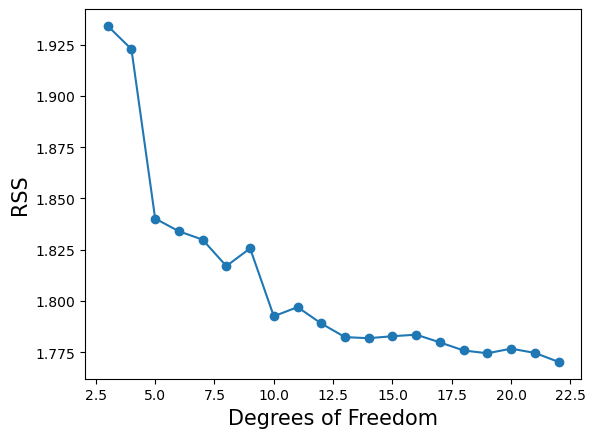

In [33]:
plt.scatter(range(3, 23), df_rss, marker = 'o', label = 'Points')
plt.plot(range(3, 23), df_rss, label = 'Line')
plt.xlabel('Degrees of Freedom', fontsize = 15)
plt.ylabel('RSS', fontsize = 15);

#### K-fold Cross-Validation
Lastly, let's use cross-validation to get a better feel for which degrees of freedom we should use. We'll start by using 10-fold cross-validation for degrees of freedom = 4-13 and plot the average test MSE.

The arguments to `cross_validate()` are as follows: an
object with the appropriate `fit()`, `predict()`,
and `score()` methods,  an
array of features `X` and a response `Y`. 
We also included an additional argument `cv` to `cross_validate()`; specifying an integer
$K$ results in $K$-fold cross-validation. We have provided a value 
corresponding to the total number of observations, which results in
leave-one-out cross-validation (LOOCV). The `cross_validate()`  function produces a dictionary with several components;
we simply want the cross-validated test score here (MSE), which is estimated to be 24.23.

In [34]:
cv = KFold(n_splits = 10,
           shuffle = True,
           random_state = 0)

cv_mse = np.zeros(10)
D = np.array(y)
M = sklearn_sm(sm.OLS)

for i, d in enumerate(range(1, 11)):
    bs_dis_df = MS([bs('dis', df = d + 3)])
    X = bs_dis_df.fit_transform(boston)
    X = np.array(X)
    
    M_CV = cross_validate(M,
                          X,
                          D,
                          cv = cv)
    cv_mse[i] = np.mean(M_CV['test_score'])
print(cv_mse)

[0.0038661  0.00369935 0.00369673 0.00369353 0.00368485 0.00371916
 0.00367062 0.00368067 0.00367021 0.00368025]


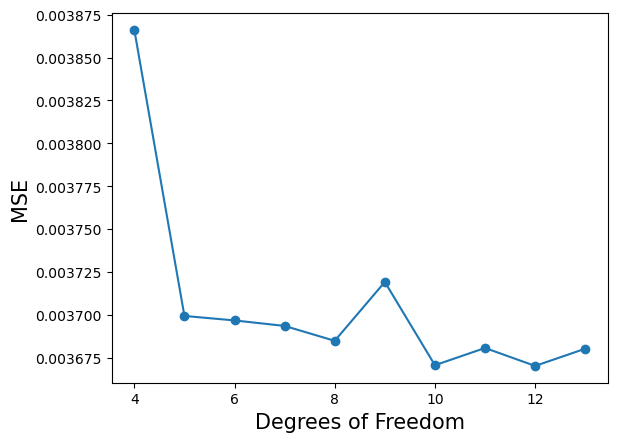

In [35]:
plt.scatter(range(4, 14), cv_mse, marker = 'o', label = 'Points')
plt.plot(range(4, 14), cv_mse, label = 'Line')
plt.xlabel('Degrees of Freedom', fontsize = 15)
plt.ylabel('MSE', fontsize = 15);

Using 10 fold cross validation, we can see that the MSE generally decreases as the degrees of freedom increase. However, the differences among models (greater than 4 df) are negligible.

Now let's try 20-fold cross-validation for degrees of freedom = 4-40 and plot MSE.

In [36]:
cv = KFold(n_splits = 20,
           shuffle = True,
           random_state = 0)

cv_mse = np.zeros(37)
D = np.array(y)
M = sklearn_sm(sm.OLS)

for i, d in enumerate(range(1, 38)):
    bs_dis_df = MS([bs('dis', df = d + 3)])
    X = bs_dis_df.fit_transform(boston)
    X = np.array(X)
    
    M_CV = cross_validate(M,
                          X,
                          D,
                          cv = cv, 
                          return_estimator = True)
    cv_mse[i] = np.mean(M_CV['test_score'])
print(cv_mse)

[0.0038808  0.00372249 0.00372301 0.00372272 0.00370994 0.00374265
 0.00369205 0.00371213 0.00369957 0.00370835 0.00373754 0.00377066
 0.00378743 0.00379479 0.00379139 0.00380548 0.0038301  0.0038433
 0.00384159 0.00386076 0.0039017  0.00396154 0.00404578 0.00410777
 0.00414337 0.00418626 0.00425925 0.00442203 0.00461059 0.00467836
 0.00456731 0.00453607 0.00434479 0.00424399 0.00429407 0.00421589
 0.00421549]


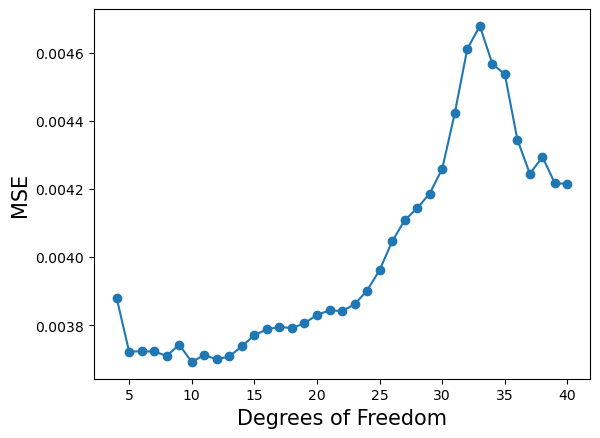

In [37]:
plt.scatter(range(4, 41), cv_mse, marker = 'o', label = 'Points')
plt.plot(range(4, 41), cv_mse, label = 'Line')
plt.xlabel('Degrees of Freedom', fontsize = 15)
plt.ylabel('MSE', fontsize = 15);

We can see that the MSE actually increase as we add the number of knots in the model. Therefore, it is better to keep the number of knots smaller.

## Exercise: Predicting Out of State Tuition

This exercise is adapted from Chapter 7, Exercise 10 in ISLP. 

In this exercise, we use the `College` data set, which is part of the `ISLP` package. This data set includes statistics for a large number of US Colleges from the 1995 issue of US News and World Report. It includes 777 observations on the following 18 variables:
- `Private`: A factor with levels No and Yes indicating private or public university
- `Apps`: Number of applications received
- `Accept`: Number of applications received
- `Enroll`: Number of new students enrolled
- `Top10perc`: Pct. new students from top 10% of H.S. class
- `Top25perc`: Pct. new students from top 25% of H.S. class
- `F.Undergrad`: Number of fulltime undergraduates
- `P.Undergrad`: Number of parttime undergraduates
- `Outstate`: Out-of-state tuition
- `Room.Board`: Room and board costs
- `Books`: Estimated book costs
- `Personal`: Estimated personal spending
- `PhD`: Pct. of faculty with Ph.D.'s
- `Terminal`: Pct. of faculty with terminal degree
- `S.F.Ratio`: Student/faculty ratio
- `perc.alumni`: Pct. alumni who donate
- `Expend`: Instructional expenditure per student
- `Grad.Rate`: Graduation rate

The following code loads in the data and gives a summary of the variables. 

In [38]:
college = load_data('College')
college.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


We can also look at the first few rows of the data.

In [39]:
college.head(n = 5)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


And just for fun let's look at the row for Virginia Tech. (We know this is Tech since the R version has row names).

In [40]:
college.iloc[713]

Private           No
Apps           15712
Accept         11719
Enroll          4277
Top10perc         29
Top25perc         53
F.Undergrad    18511
P.Undergrad      604
Outstate       10260
Room.Board      3176
Books            740
Personal        2200
PhD               85
Terminal          89
S.F.Ratio       13.8
perc.alumni       20
Expend          8944
Grad.Rate         73
Name: 713, dtype: object

Let's convert the `Private` column to a category.

In [41]:
college['Private'] = college['Private'].astype('category')

For this exercise, the goal is to predict out of state tuition (column `Outstate`) using the other variables as predictors. 

### Part 1: Forward Selection

We'll start by splitting into a training and test set.  We'll use `random_state` to set a seed for reproducibility and we'll use 20% of the data for our test set.

In [42]:
college_train, college_test = train_test_split(college, random_state = 47, test_size = 0.2)

Notice that there's quite a few columns to use as predictors.  Let's use forward selection to help pair down on the number of columns we use. We'll look at Mallow's $C_p$ and BIC for each subset.  Since Mallow's $C_p$ is not built into `sklearn`, we'll use two different functions to calculate this. The first is `nCp` created in ISLP chapter 5 which we'll use within the forward selection methods. Note, this function returns the negative $C_p$ because `sklearn` tries to maximize a score.  The second is `simpleCp` which just calculates $C_p$ for a set of predictions (`Y_hat`) and true responses (`Y`) where `n` is the number of observations and `p` is the number of predictors (including the intercept).

In [43]:
# Functions for Mallow's Cp
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

def simpleCp(sigma2, Yhat, Y, n, p):
    "Cp statistic"
    RSS = np.sum((Y - Yhat)**2)
    return (RSS + 2 * p * sigma2) / n 

Before doing Forward selection, we also need to estimate variance $\sigma^2$, which we'll do by fitting the full model and estimate.  

In [44]:
design = MS(college_train.columns.drop('Outstate')).fit(college_train)
Y = np.array(college_train['Outstate'])
X = design.transform(college_train)
sigma2 = OLS(Y, X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments --- the last three in the definition of `nCp()` above. We use the function `partial()` (see ISLP Section 5.3.3) to freeze the first argument with our estimate of $\sigma^2$.

In [45]:
neg_Cp = partial(nCp, sigma2)

Along with a score we need to specify the search strategy. This is done through the object `Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. We'll do this to get a look at what variables forward selection using $C_p$ suggests.

In [46]:
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = 15)
college_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring = neg_Cp)
college_Cp.fit(college_train, Y)
college_Cp.selected_state_

('Expend',
 'Grad.Rate',
 'Personal',
 'Private',
 'Room.Board',
 'S.F.Ratio',
 'Terminal',
 'Top10perc',
 'perc.alumni')

It looks like it suggests the above 9 variables.  Now let's see what $C_p$ looks like for each step of forward selection.  To do so, we use the function `sklearn_selection_path()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. We'll also specify our $C_p$ scoring function. Using this framework we can get Mallow's $C_p$ for each step.

In [47]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction = 'forward')
full_path = sklearn_selection_path(OLS, strategy,scoring = neg_Cp)

We also need to get the predicted values for each step.

In [48]:
full_path.fit(college_train, Y)
Yhat_in = full_path.predict(college_train)

Now we can get Mallow's $C_p$ for each step via the following loop and plot.

In [49]:
college_cp = np.zeros(15)

for i in range(0, 15):
    college_cp[i] = simpleCp(sigma2, Yhat_in[:,i],  Y, n = Yhat_in.shape[0], p = i + 1)
print(college_cp)

[16308765.12829332  8838876.5909847   6344881.91054619  5222395.77599316
  4433314.9933664   4127447.82974655  3927685.48187639  3912344.69142598
  3904764.08568775  3897856.29506155  3898864.55038553  3808455.14677
  3729657.00477547  3733181.72509535  3738102.45751106]


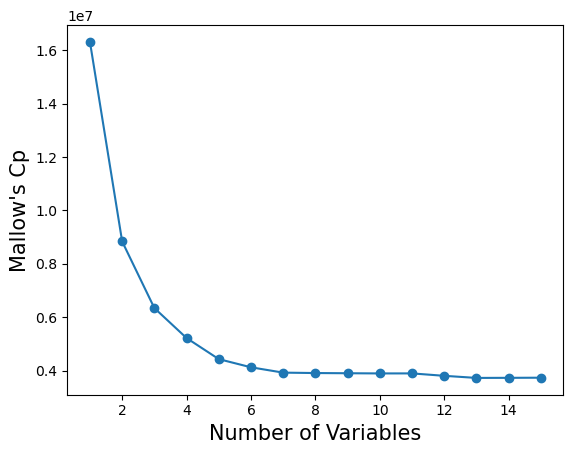

In [50]:
plt.scatter(range(1, 16), college_cp, marker = 'o', label = 'Points')
plt.plot(range(1, 16), college_cp, label = 'Line')
plt.xlabel('Number of Variables', fontsize = 15)
plt.ylabel("Mallow's Cp", fontsize = 15);

Based on the plot, we see the last notable dip around 13 variables. Even though Mallow's $C_p$ continues to decrease as we add predictors, we probably want to consider fewer variables.  Let's so the same thing but using BIC instead. We'll need to define two functions again for calculating BIC.

In [51]:
# Functions for BIC
def nBIC(estimator, X, Y):
    "Negative BIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    log_likelihood = np.sum(norm.logpdf(Y, loc = Yhat, scale = np.std(Y)))
    RSS = np.sum((Y - Yhat)**2)
    return -(-2 * log_likelihood + p * np.log(n))

def simpleBIC(Yhat, Y, n, p):
    "BIC"
    log_likelihood = np.sum(norm.logpdf(Y, loc = Yhat, scale = np.std(Y)))
    RSS = np.sum((Y - Yhat)**2)
    return -2 * log_likelihood + p * np.log(n)

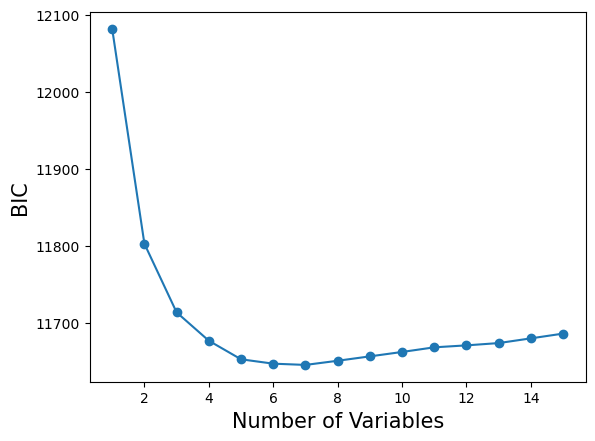

In [52]:
full_path = sklearn_selection_path(OLS, strategy, scoring = nBIC)
full_path.fit(college_train, Y)
Yhat_in = full_path.predict(college_train)

college_bic = np.zeros(15)

for i in range(0, 15):
    college_bic[i] = simpleBIC(Yhat_in[:, i],  Y, n = Yhat_in.shape[0], p = i + 1)
college_bic

# plot BIC
plt.scatter(range(1, 16), college_bic, marker = 'o', label = 'Points')
plt.plot(range(1, 16), college_bic, label = 'Line')
plt.xlabel('Number of Variables', fontsize = 15)
plt.ylabel("BIC", fontsize = 15);

Based on BIC, it looks like 6 or 7 variables is more reasonable. Let's see what variables BIC suggest. Notice the list looks a little different than what we saw with $C_p$.  Let's use the $C_p$ list for now. 

In [53]:
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = 15)
college_BIC = sklearn_selected(OLS,
                               strategy,
                               scoring = nBIC)
college_BIC.fit(college_train, Y)
college_BIC.selected_state_

('Expend', 'Grad.Rate', 'Private', 'Room.Board', 'Terminal', 'perc.alumni')

### Part 2: Fit a Generalized Additive Model (GAM)

Now that we've used forward selection to identify that we should use 9 predictors based on Mallow's $C_p$ and which predictors those should be, let's fit a generalize additive model with smoothing splines using those 9 predictors.  

A smoothing spline is a special case of a GAM with squared-error loss
and a single feature. To fit GAMs in `Python` we will use the
`pygam` package which can be installed via `pip install pygam`. The
estimator `LinearGAM()` uses squared-error loss.
The GAM is specified by associating each column
of a model matrix with a particular smoothing operation:
`s` for smoothing spline; `l` for linear, and `f` for factor or categorical variables.
The argument `0` passed to `s` below indicates that this smoother will
apply to the first column of a feature matrix. Below, we pass it a
matrix with a single column: `X_age`. The argument `lam` is the penalty parameter $\lambda$ as discussed in Section 7.5.2.

First, we'll manually specify a cubic natural spline for each numeric predictor.  Then we'll combine them with the categorical variable `Private`.

In [54]:
gam_full = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + f(8))
Xgam = np.column_stack([college_train[['Expend']],
                        college_train[['Grad.Rate']],
                        college_train[['Personal']],
                        college_train[['Room.Board']],
                        college_train[['S.F.Ratio']],
                        college_train[['Terminal']],
                        college_train[['Top10perc']],
                        college_train[['perc.alumni']],
                        college_train['Private'].cat.codes])
gam_full = gam_full.fit(Xgam, college_train['Outstate'])

Now we can visualize the partial dependence of each variable on out of state tuition.

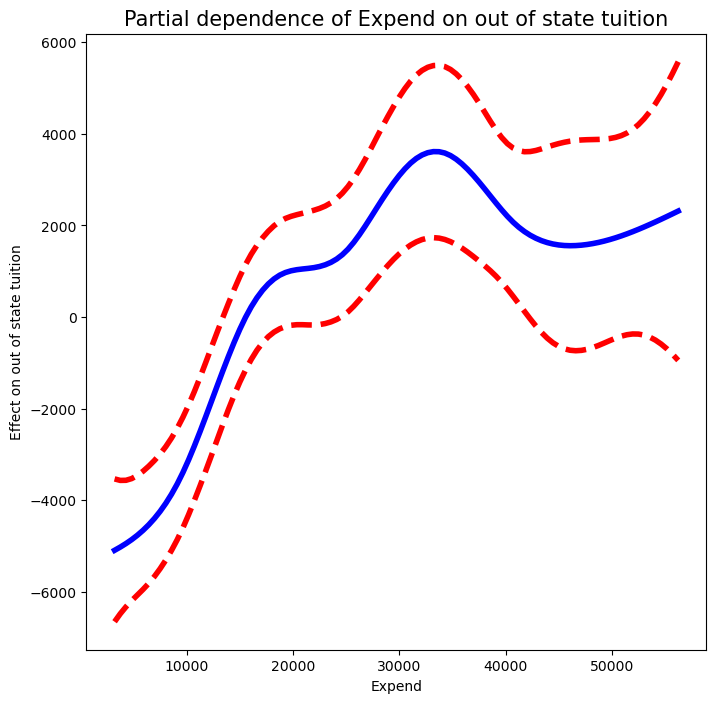

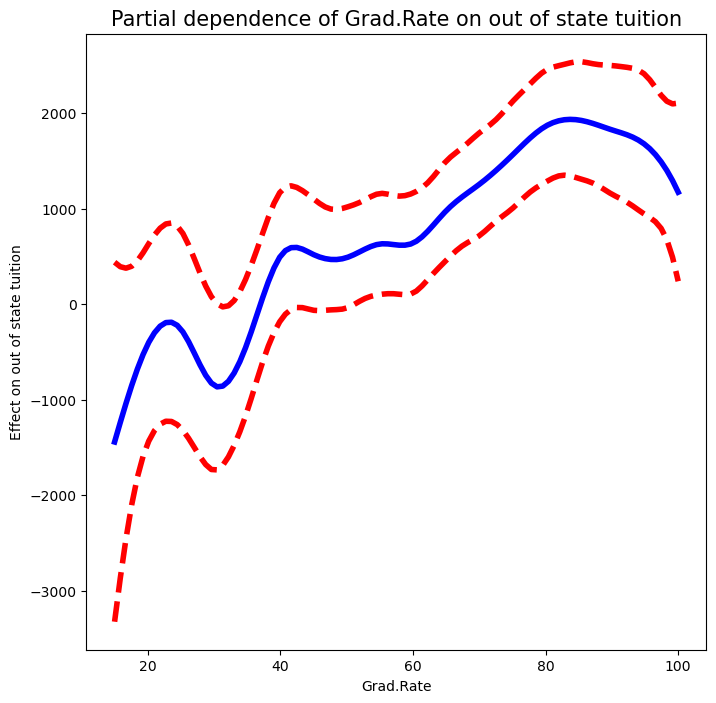

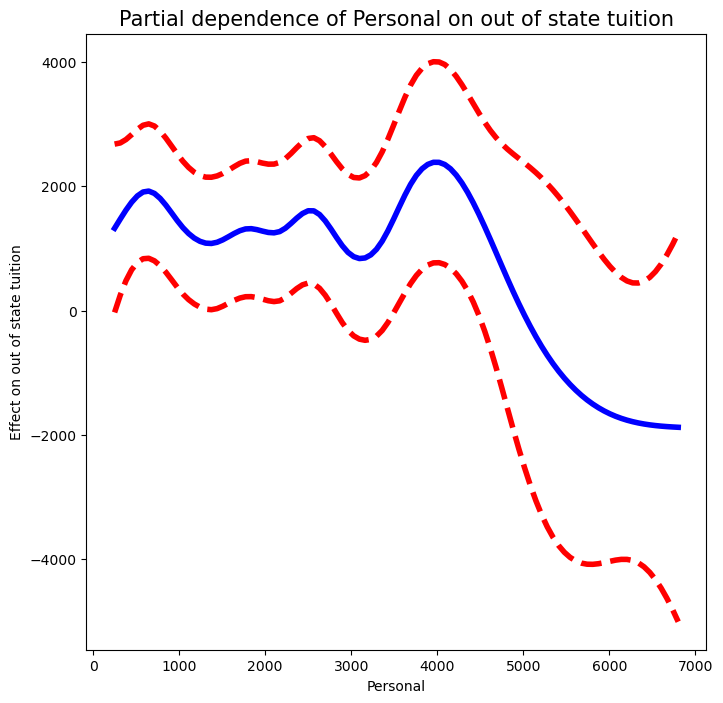

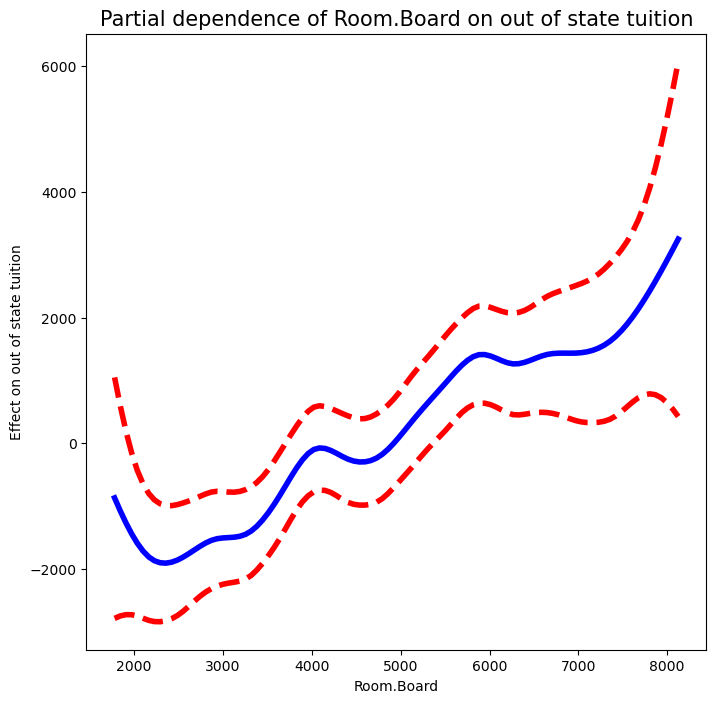

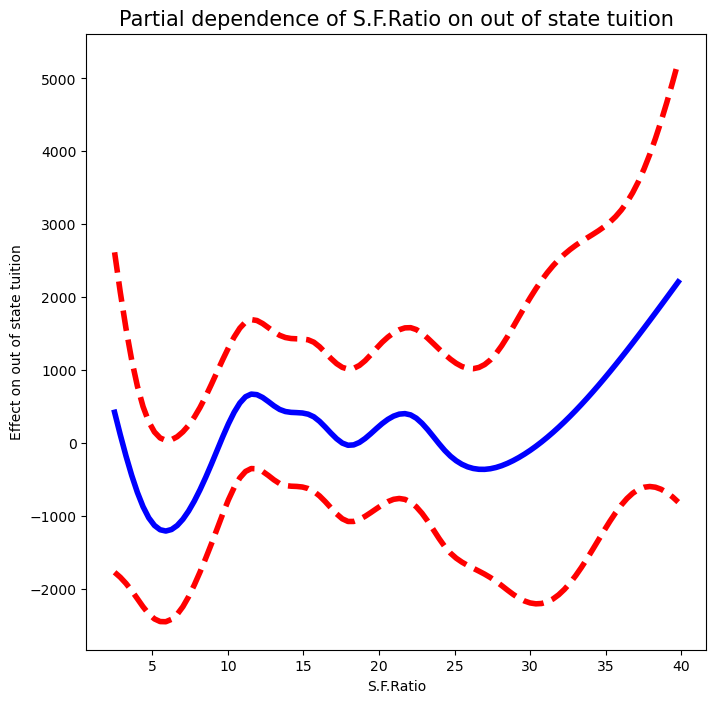

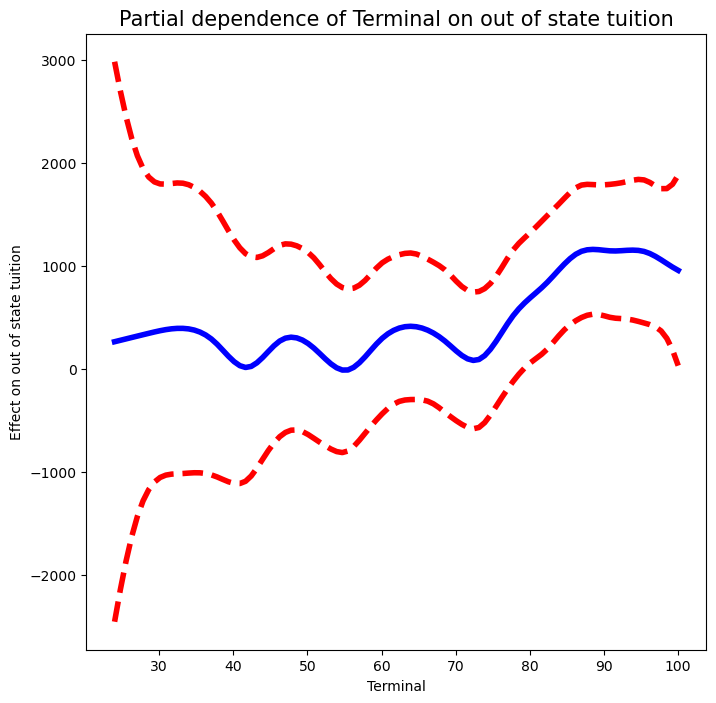

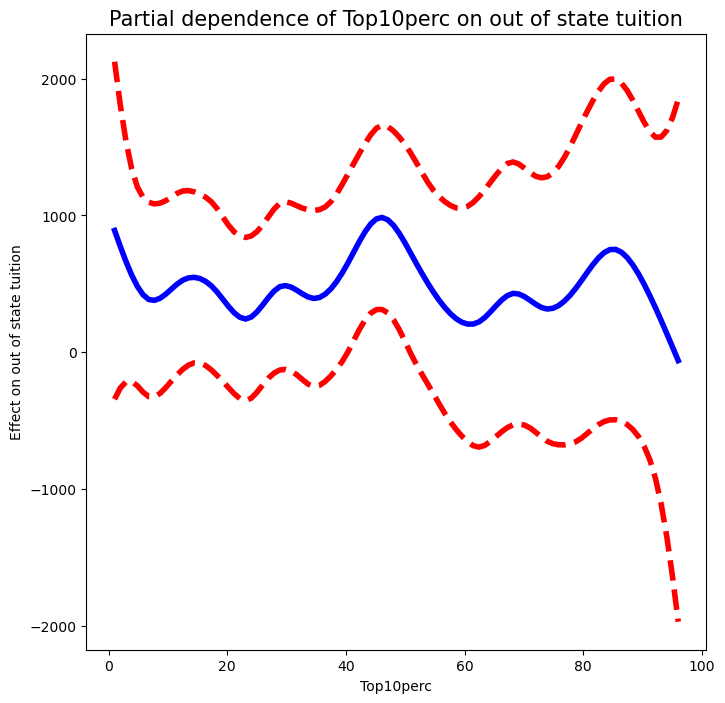

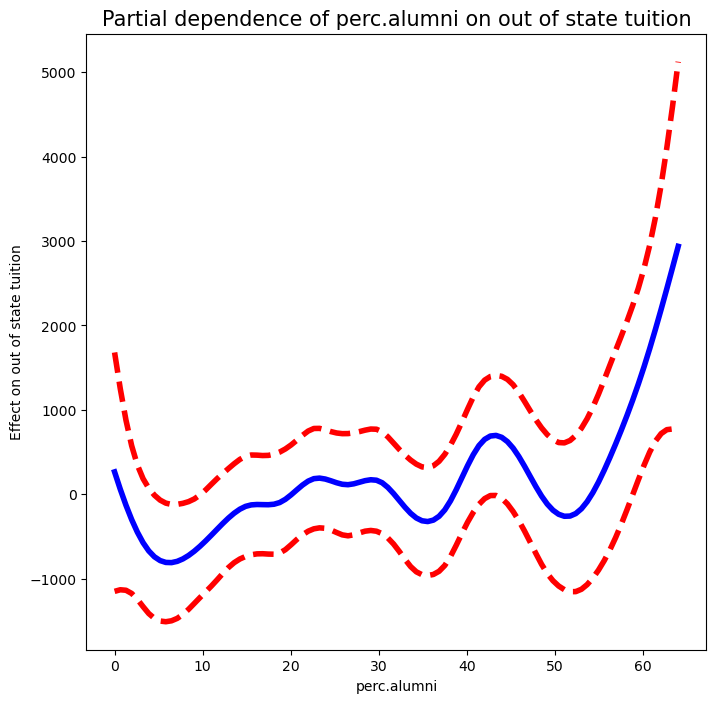

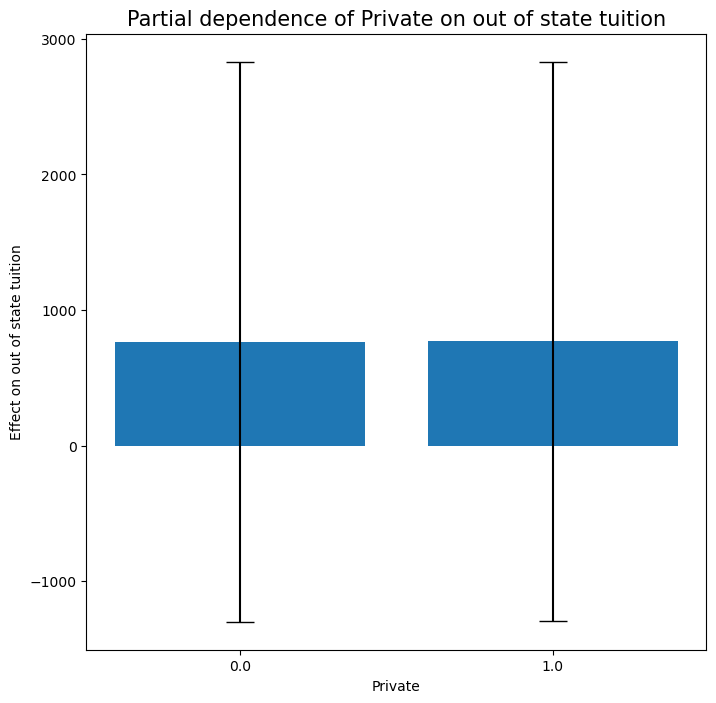

In [55]:
cp_vars = ['Expend', 'Grad.Rate', 'Personal', 'Room.Board', 'S.F.Ratio', 'Terminal', 'Top10perc', 'perc.alumni', "Private"]

for i in range(0, 9):
    fig, ax = subplots(figsize = (8, 8))
    plot_gam(gam_full, i, ax = ax)
    ax.set_xlabel(cp_vars[i])
    ax.set_ylabel('Effect on out of state tuition')
    ax.set_title('Partial dependence of ' + cp_vars[i] + ' on out of state tuition', fontsize = 15);

Below is a summary of the GAM.

In [56]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     83.6026
Link Function:                     IdentityLink Log Likelihood:                                 -9866.9294
Number of Samples:                          621 AIC:                                            19903.0639
                                                AICc:                                           19930.1174
                                                GCV:                                          4167913.0311
                                                Scale:                                        3171884.5083
                                                Pseudo R-Squared:                                   0.8316
Feature Function                  Lam

/tmp/ipykernel_2073/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


Now we can predict the testing set with this GAM and get the testing MSE.

In [57]:
Xgam_test = np.column_stack([college_test[['Expend']],
                        college_test[['Grad.Rate']],
                        college_test[['Personal']],
                        college_test[['Room.Board']],
                        college_test[['S.F.Ratio']],
                        college_test[['Terminal']],
                        college_test[['Top10perc']],
                        college_test[['perc.alumni']],
                        college_test['Private'].cat.codes])
Yhat = gam_full.predict(Xgam_test)
round(mean_squared_error(Yhat, college_test.Outstate), 3)

4226301.707

Now let's compare testing MSE from the GAM to a basic linear model with the same variables.

In [58]:
allvars = college_train[cp_vars]
design = MS(allvars)
X_train = design.fit_transform(college_train)
X_test = design.fit_transform(college_test)
model = sm.OLS(college_train.Outstate, X_train)
results = model.fit()
Yhat2 = np.asarray(results.predict(exog = X_test))
round(mean_squared_error(Yhat2, college_test.Outstate ), 3)

4856290.595

We can see that the MSE for the GAM is slightly lower than the linear model.

## Exercise: Predicting Miles Per Gallon
This exercise is adapted from Chapter 7, Exercise 8 in ISLP. 

In this exercise, we'll use the `Auto` data from the `ISLP` package. This dataset includes information on 392 vehicles for the following 9 variables:
 - `mpg`: Miles per gallon  
 - `cylinders`: Number of cylinders between 4 and 8
 - `displacement`: Engine displacement (cu. inches)
 - `horsepower`: Engine horsepower
 - `weight`: Vehicle weight (lbs.)
 - `acceleration`: Time to accelerate from 0 to 60 mph (sec.)
 - `year`: Model year (modulo 100)
 - `origin`: Origin of car (1. American, 2. European, 3. Japanese)
 - `name`: Vehicle name

Let's load the data and convert our categorical factors to categories.

In [59]:
auto = load_data('Auto')
auto['cylinders'] = auto['cylinders'].astype('category')
auto['origin'] = auto['origin'].astype('category')

We can also look at the first few rows of the data.

In [60]:
auto.head(n = 5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


We'll also split into a training and test set.

In [61]:
auto_train, auto_test = train_test_split(auto, random_state=4, test_size=0.2)

Our goal is to predict `mpg` using the other variables. Let's start with a linear regression model. As usual, we fit the model on the training set, predict the test set, and get test MSE.

In [62]:
allvars = auto.columns.drop(['mpg'])
X_train = MS(allvars).fit_transform(auto_train)
X_test = MS(allvars).fit_transform(auto_test)

modelOLS = sm.OLS(auto_train.mpg, X_train)
resultsOLS = modelOLS.fit()
Yhat = resultsOLS.predict(exog = X_test)
summarize(resultsOLS)

,coef,std err,t,P>|t|
intercept,-19.0424,5.311,-3.585,0.000
cylinders[4],7.3383,1.917,3.827,0.000
cylinders[5],8.5162,2.977,2.861,0.005
cylinders[6],3.9119,2.115,1.850,0.065
cylinders[8],6.1074,2.440,2.503,0.013
displacement,0.0161,0.009,1.896,0.059
horsepower,-0.0357,0.016,-2.226,0.027
weight,-0.0058,0.001,-7.332,0.000
acceleration,-0.0567,0.113,-0.504,0.615
year,0.7136,0.056,12.750,0.000


The testing MSE is about 9.5. 

In [63]:
round(mean_squared_error(Yhat, auto_test.mpg ), 3)

9.539

### Part 1: Polynomial Regression

Now let's try a polynomial regression with up to the 5th order of each numeric predictor (except year). Since having up to the 5th order of each predictor creates alot of variables, we'll first use forward selection to narrow down what variables to include.  We'll follow the same steps as we saw in the previous exercise.  First let's set up our training matrix `X_train` and get an estimate of $\sigma^2$ under the full polynomial regression model and set that as our first parameter in `nCp`.

In [64]:
Y = np.array(auto_train['mpg'])
X = MS([poly('displacement', degree = 5),
              poly('horsepower', degree = 5),
              poly('weight', degree = 5),
             poly('acceleration', degree = 5),
            'cylinders',
            'year',
            'origin']).fit_transform(auto_train)
sigma2 = OLS(Y, X).fit().scale
neg_Cp = partial(nCp, sigma2)
sigma2

7.898243339138067

Now let's figure out how many variables are suggested under Mallow's $C_p$.

In [65]:
design = MS(X.columns.drop('intercept')).fit(X)
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = 20)
auto_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring = neg_Cp)
auto_Cp.fit(X, Y)
auto_Cp.selected_state_

('cylinders[4]',
 'cylinders[5]',
 'origin[3]',
 'poly(acceleration, degree=5)[0]',
 'poly(acceleration, degree=5)[1]',
 'poly(horsepower, degree=5)[0]',
 'poly(horsepower, degree=5)[1]',
 'poly(weight, degree=5)[0]',
 'poly(weight, degree=5)[1]',
 'poly(weight, degree=5)[2]',
 'year')

Looks like it suggests the following variables:  `cylinders`, `origin`, `acceleration`, `acceleration`$^2$, `horsepower`, `horsepower`$^2$, `weight`, `weight`$^2$, `weight`$^3$, and `year`. Let's visualize $C_p$ through the forward selection steps.

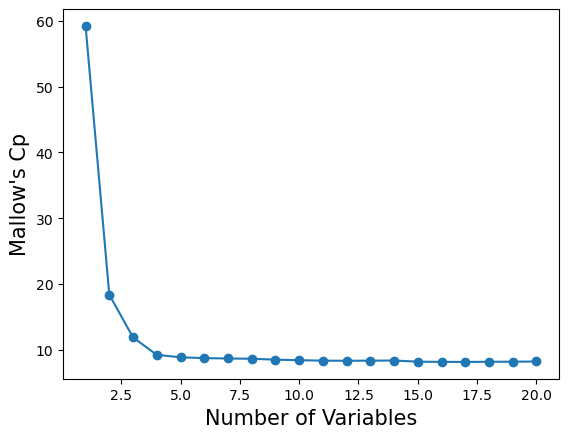

In [66]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction = 'forward')
full_path = sklearn_selection_path(OLS, strategy, scoring = neg_Cp)
full_path.fit(X, Y)
Yhat_in = full_path.predict(X)

auto_cp = np.zeros(20)
for i in range(0, 20):
    auto_cp[i] = simpleCp(sigma2, Yhat_in[:, i],  Y, n = Yhat_in.shape[0], p = i + 1)
auto_cp

# plot Cp
plt.scatter(range(1, 21), auto_cp, marker = 'o', label = 'Points')
plt.plot(range(1, 21), auto_cp, label = 'Line')
plt.xlabel('Number of Variables', fontsize = 15)
plt.ylabel("Mallow's Cp", fontsize = 15)
plt.show()

Let's try the same thing with BIC.

In [67]:
design = MS(X.columns.drop('intercept')).fit(X)
strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = 20)
auto_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring = nBIC)
auto_Cp.fit(X, Y)
auto_Cp.selected_state_

('poly(weight, degree=5)[0]', 'poly(weight, degree=5)[1]', 'year')

Using BIC, it selects `weight`, `weight`$^2$, and `year.

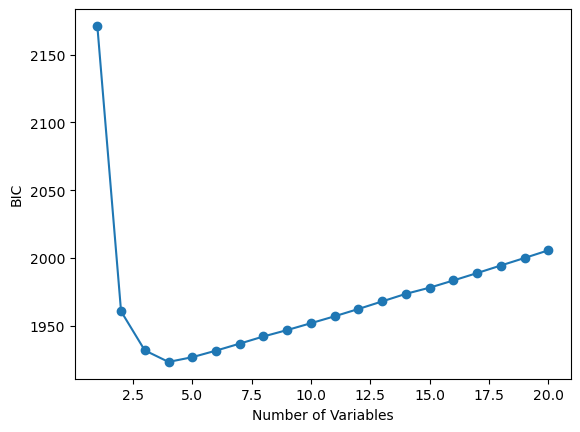

In [68]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction = 'forward')
full_path = sklearn_selection_path(OLS, strategy, scoring = nBIC)
full_path.fit(X, Y)
Yhat_in = full_path.predict(X)

auto_bic = np.zeros(20)
for i in range(0,20):
    auto_bic[i] = simpleBIC(Yhat_in[:,i],  Y, n=Yhat_in.shape[0], p=i+1)
auto_bic

# plot BIC
plt.scatter(range(1,21), auto_bic, marker='o', label='Points')
plt.plot(range(1,21), auto_bic, label='Line')
plt.xlabel('Number of Variables')
plt.ylabel("BIC");

BIC seems to suggest only 2 or 3 predictors is best.  Let's use the list of variables from Mallow's $C_p$

In [69]:
poly_dis = MS([poly('horsepower', degree = 2),
              poly('weight', degree = 3),
             poly('acceleration', degree = 2),
            'cylinders',
            'year',
            'origin']).fit(auto_train)
M = sm.OLS(auto_train.mpg, poly_dis.transform(auto_train)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,-40.3468,4.269,-9.451,0.000
"poly(horsepower, degree=2)[0]",-41.0809,10.294,-3.991,0.000
"poly(horsepower, degree=2)[1]",9.1247,4.741,1.925,0.055
"poly(weight, degree=3)[0]",-57.0508,10.320,-5.528,0.000
"poly(weight, degree=3)[1]",19.3588,4.482,4.319,0.000
"poly(weight, degree=3)[2]",-2.4322,3.436,-0.708,0.480
"poly(acceleration, degree=2)[0]",-17.4245,5.083,-3.428,0.001
"poly(acceleration, degree=2)[1]",12.0432,3.828,3.146,0.002
cylinders[4],7.4443,1.698,4.384,0.000
cylinders[5],9.8301,2.664,3.690,0.000


In [70]:
preds = M.predict(exog = poly_dis.transform(auto_test))

Notice the testing MSE of about 7.6 with this Polynomial regression model is lower than the multiple linear regression model.

In [71]:
round(mean_squared_error(preds, auto_test.mpg ), 3)

7.602

### Part 2: Fit a Generalized Additive Model with Splines

Lastly, we'll try a GAM with regression splines, predict using the test data, and return the test MSE.

In [72]:
gam_full = LinearGAM(s(0) +
                     s(1) +
                     s(2) +
                     s(3) +
                     s(4) +
                     f(5) +
                     f(6))
Xgam = np.column_stack([auto_train['weight'],
                        auto_train['year'],
                        auto_train['displacement'],
                        auto_train['acceleration'],
                        auto_train['horsepower'],
                        auto_train['cylinders'].cat.codes,
                        auto_train['origin'].cat.codes])
gam_full = gam_full.fit(Xgam, auto_train.mpg)

In [73]:
Xgam_test = np.column_stack([auto_test['weight'],
                        auto_test['year'],
                        auto_test['displacement'],
                        auto_test['acceleration'],
                        auto_test['horsepower'],
                        auto_test['cylinders'].cat.codes,
                        auto_test['origin'].cat.codes])
Yhat = gam_full.predict(Xgam_test)
round(mean_squared_error(Yhat, auto_test.mpg ), 3)

7.737

Notice the MSE is a little higher in this case.